In [ ]:
import TimeSliceImport
import numpy as np
import keras
import random
from keras.models import Sequential

from keras.layers import (Dense, Dropout, Activation, Conv1D,Conv2D, Flatten)
from keras.layers import (MaxPooling1D,BatchNormalization,MaxPooling2D, GlobalAveragePooling1D,LSTM)
from keras.optimizers import SGD
from sklearn import (metrics,preprocessing)
import RamanPlotTools as pt
import matplotlib.pyplot as plt
from matplotlib.image import NonUniformImage
from mpl_toolkits import mplot3d
from keras.optimizers import Adam


Using TensorFlow backend.


In [ ]:
from keras.backend import tensorflow_backend as backend
print(backend.device_lib.list_local_devices())

In [2]:
path="/home/waseda/Desktop/shared/SKYP_KYP_SYP"
numClasses=4
types=["PS", "yeast","spore","kleb"]
spectra=TimeSliceImport.importData(path,types)
classes=list(map(lambda x:TimeSliceImport.RamanSample.mappings[x],types))
sortedTypesTuples=sorted(zip(types,classes),key=lambda x:x[1])
sortedTypes=[x[0] for x in sortedTypesTuples]

startPNT=201


def makeRandomData(filter="NONE",start=startPNT,end=1600,points=1000,removeBG=False):
    trainingSamples, validationSamples = TimeSliceImport.splitData(spectra, 0.25)
    trainingSpectraList = list(map(lambda x: x.interpolatedSpectra(start, end, points, filter=filter,removeBackground=removeBG), trainingSamples))
    validationSpectraList = list(map(lambda x: x.interpolatedSpectra(start, end, points,filter=filter,removeBackground=removeBG), validationSamples))
    trainingData,trainingClasses,validationData,validationClasses = TimeSliceImport.makeSVMInputData(trainingSpectraList, validationSpectraList)

    oneHotTrainingClasses=keras.utils.to_categorical(trainingClasses,num_classes=numClasses)
    oneHotValidationClasses=keras.utils.to_categorical(validationClasses,num_classes=numClasses)
    return trainingData, oneHotTrainingClasses, validationData, oneHotValidationClasses

trainingData, oneHotTrainingClasses, validationData, oneHotValidationClasses=makeRandomData()

def makePerCellTrainingData():
    trainingSamples, validationSamples = TimeSliceImport.splitData(spectra, 0.25)
    trainingSpectraList = list(map(lambda x: x.interpolatedSpectra(start, end, points), trainingSamples))
    validationSpectraList = list(map(lambda x: x.interpolatedSpectra(start, end, points), validationSamples))

    trainingData,trainingClasses,validationData,validationClasses = TimeSliceImport.makeMultiDimensionalData(trainingSpectraList=trainingSpectraList,
                                                                                                         validationSpectraList=validationSpectraList,
                                                                                                         normalize=True,
                                                                                                         oneHot=True)
    return trainingData,trainingClasses,validationData,validationClasses



def scalarClassesFromOneHotArray(oneHotArray):
    return np.argmax(oneHotArray,axis=1)

def plotResult(truth,result, score, normalize=False):
    pt.plotResult(scalarClassesFromOneHotArray(result),scalarClassesFromOneHotArray(truth),sortedTypes)
    mtrx = metrics.confusion_matrix(scalarClassesFromOneHotArray(truth),scalarClassesFromOneHotArray(result))
    pt.plotConfusionMatrix(mtrx,sortedTypes,"Classification Result (%.03g )" % score, normalize=normalize)

def plotLearning(history):
    
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Training Accuracy', 'Cross-Validation Accuracy'])
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Training Loss', 'Cross-Validation Loss'])
    plt.show()

Test Background Removal Parameters

glassAg_SKYP_yeast_10.txt


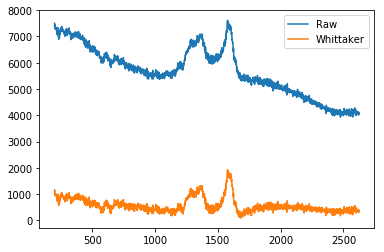

In [3]:
randomSample=random.choice(spectra)
print(randomSample.name)
randomSpectrum=(np.transpose(randomSample.spectra)[0])
backgroundCorrectedSpectrum=randomSample.removeBackground(randomSpectrum,lambdaVal=5000)
xData=spectra[0].waveNumbers
plt.plot(xData,randomSpectrum)
plt.plot(xData,backgroundCorrectedSpectrum)
plt.legend(['Raw', 'Whittaker'])
plt.show()

Test BackgroundRemoval for many Spectra

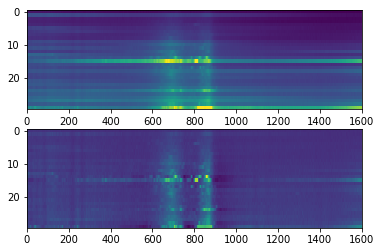

In [4]:
numTicks=8
backgroundCorrectedSpectra=randomSample.backgroundRemovedSpectra(lambdaVal=5000)
fig, axs=plt.subplots(2,1)
axs[0].imshow(np.transpose(randomSample.spectra),aspect="auto")
axs[1].imshow(np.transpose(backgroundCorrectedSpectra),aspect="auto")
#todo properly plot against wavenumber

# print(randomSample.waveNumbers.shape)
# print(np.transpose(backgroundCorrectedSpectra).shape)
# xLoc=np.linspace(0,randomSample.waveNumbers.shape,numTicks)
# xTick=np.linspace(randomSample.waveNumbers[0],randomSample.waveNumbers[-1],numTicks)
# axs.set_xticks(xLoc)
# axs.set_xticklabels(xTick)




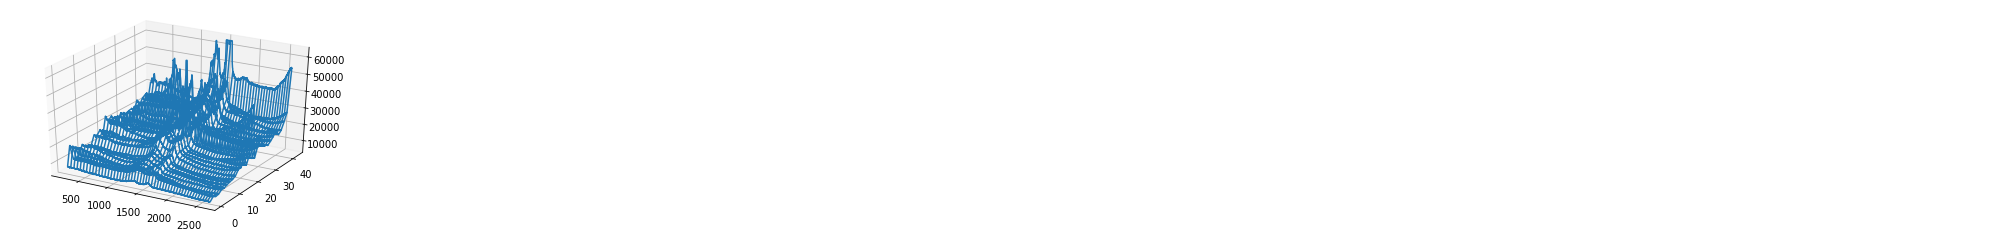

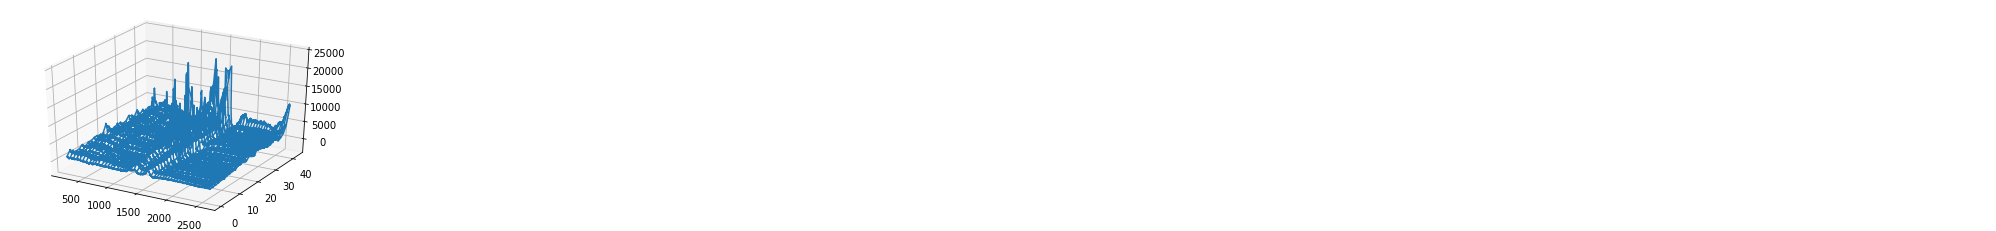

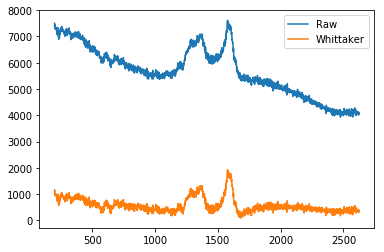

In [5]:
fig3D = plt.figure()
ax3d = fig3D.add_subplot(111, projection='3d')
X,Y=np.meshgrid(randomSample.waveNumbers,randomSample.times)
ax3d.plot_wireframe(X,Y,np.transpose(randomSample.spectra))
fig3D2 = plt.figure()
ax3d2 = fig3D2.add_subplot(111, projection='3d')

ax3d2.plot_wireframe(X,Y,np.transpose(backgroundCorrectedSpectra))
plt.show()

plt.plot(randomSample.waveNumbers,np.transpose(randomSample.spectra)[0])
plt.plot(randomSample.waveNumbers,np.transpose(backgroundCorrectedSpectra)[0])
# plt.plot(randomSample.waveNumbers,np.transpose(randomSample.spectra)[-1])
# plt.plot(randomSample.waveNumbers,np.transpose(backgroundCorrectedSpectra)[-1])

plt.legend(['Raw', 'Whittaker'])
plt.show()

Plot in Color

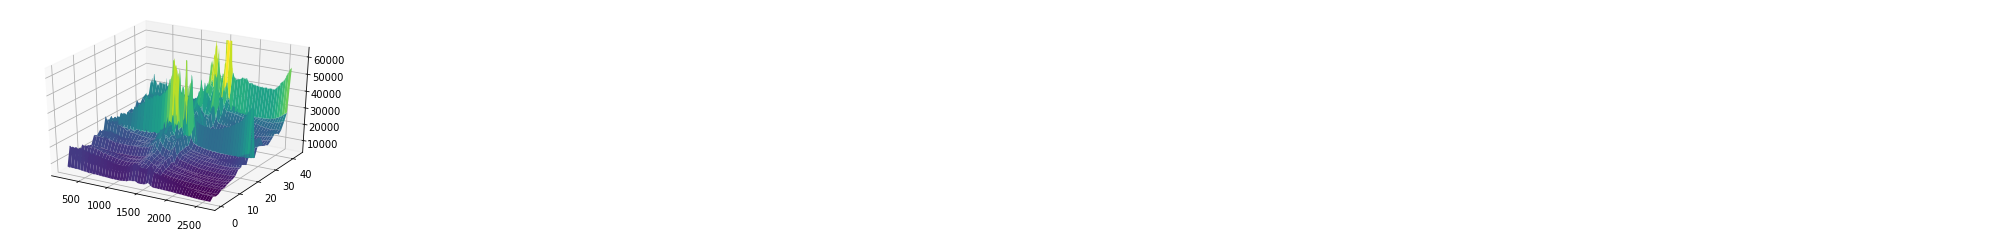

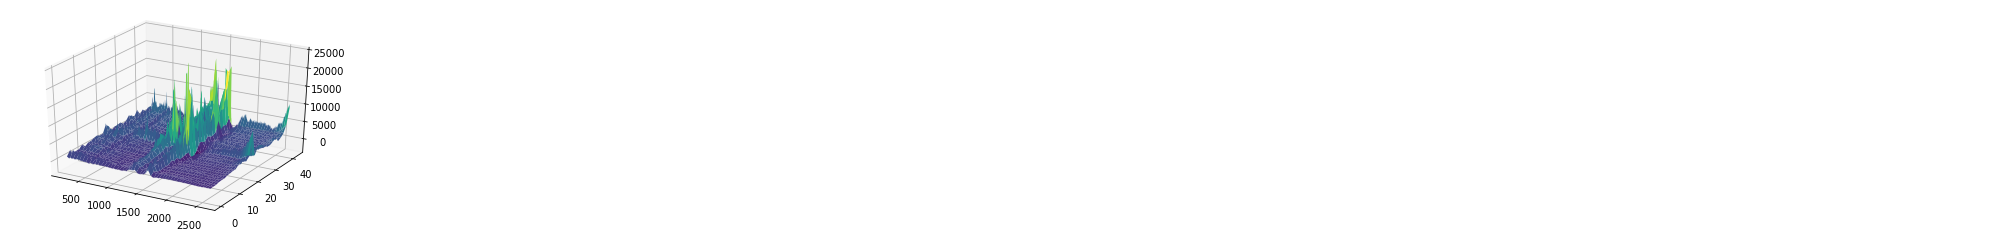

In [6]:
fig3D3 = plt.figure()
ax3d3 = fig3D3.add_subplot(111, projection='3d')
X,Y=np.meshgrid(randomSample.waveNumbers,randomSample.times)
ax3d3.plot_surface(X,Y,np.transpose(randomSample.spectra),cmap="viridis")

fig3D4 = plt.figure()
ax3d4 = fig3D4.add_subplot(111, projection='3d')
 
ax3d4.plot_surface(X,Y,np.transpose(backgroundCorrectedSpectra),cmap="viridis")
plt.show()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_355 (Dense)            (None, 128)               12928     
_________________________________________________________________
dropout_237 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_356 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_238 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_357 (Dense)            (None, 4)                 260       
Total params: 21,444
Trainable params: 21,444
Non-trainable params: 0
_________________________________________________________________
None
2500.0 False


 32/630 [>.............................] - ETA: 0s

630/630 [==============================] - 0s 65us/step


Score: 0.5492063486386859, SKScore: 0.5492063492063493
0.5492063492063493


 32/630 [>.............................] - ETA: 0s

630/630 [==============================] - 0s 65us/step


Score: 0.6857142857142857, SKScore: 0.6857142857142857
0.6857142857142857


 32/630 [>.............................] - ETA: 0s

630/630 [==============================] - 0s 70us/step


Score: 0.46984126984126984, SKScore: 0.46984126984126984
0.46984126984126984


 32/630 [>.............................] - ETA: 0s

630/630 [==============================] - 0s 65us/step


Score: 0.3841269843635105, SKScore: 0.38412698412698415
0.38412698412698415


 32/630 [>.............................] - ETA: 0s

630/630 [==============================] - 0s 69us/step


Score: 0.4253968253968254, SKScore: 0.4253968253968254
0.4253968253968254
Optimizer: Adam, Score: 0.5028571428571429


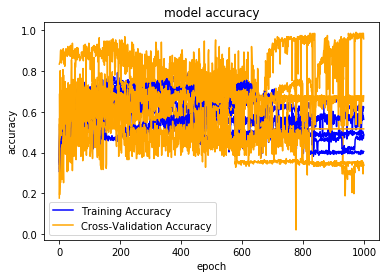

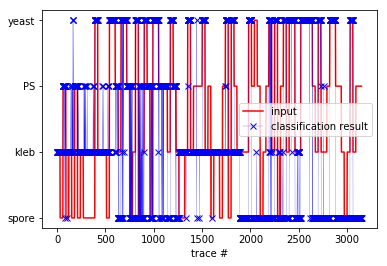

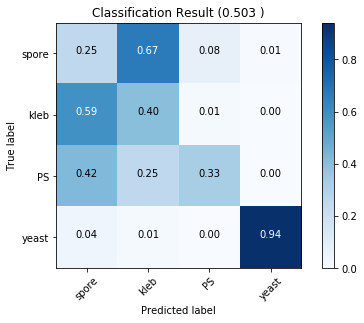

2500.0 True


 32/630 [>.............................] - ETA: 0s

630/630 [==============================] - 0s 45us/step


Score: 0.7301587301587301, SKScore: 0.7301587301587301
0.7301587301587301


 32/630 [>.............................] - ETA: 0s

630/630 [==============================] - 0s 44us/step


Score: 0.5063492063492063, SKScore: 0.5063492063492063
0.5063492063492063


In [16]:
def makeModel(lossFunction="categorical_crossentropy", optimizer="SGD", points=100):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=points))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(numClasses, activation='softmax'))
    if optimizer == "SGD":
        o = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    elif optimizer == "Adam":
        o = Adam()
    model.compile(loss=lossFunction, optimizer=o, metrics=['accuracy'])
    return model




def runModel(numRepetitions=1):
    
    scores=[]
   
    labels=[]
    l="Adam"
    rangeEnds=np.linspace(2500,800,10)
    
    for rangeEnd in rangeEnds:
        
        for removeBG in [False,True]:
        
            runScores=[]
            results=[]
            truths=[]
            label="{} {}".format(str(rangeEnd),str(removeBG))
            labels.append(label)
            dist=rangeEnd-startPNT
            print(label)
            
            for i in range(numRepetitions):

                trainingData, oneHotTrainingClasses, validationData, oneHotValidationClasses=makeRandomData(end=rangeEnd,
                                                                                                            removeBG=removeBG,
                                                                                                            points=dist)

                model=makeModel(points=trainingData.shape[1])
                history = model.fit(trainingData, oneHotTrainingClasses, epochs=1000, validation_split=0.1, verbose=0)
                score = model.evaluate(validationData, oneHotValidationClasses)
                prd = model.predict(validationData)
                skScore=metrics.accuracy_score(scalarClassesFromOneHotArray(oneHotValidationClasses),scalarClassesFromOneHotArray(prd))
                print("Score: {}, SKScore: {}".format(score[1], skScore))
                print(skScore)
                results.extend(scalarClassesFromOneHotArray(prd))
                runScores.append(skScore)
                truths.extend(scalarClassesFromOneHotArray(oneHotValidationClasses))
                plt.plot(history.history['acc'], color='blue')
                plt.plot(history.history['val_acc'], color='orange')

            avgScore=sum(runScores)/float(len(runScores))
            print("Optimizer: {}, Score: {}".format(l,avgScore))
            plt.title('model accuracy')
            plt.ylabel('accuracy')
            plt.xlabel('epoch')
            plt.legend(['Training Accuracy', 'Cross-Validation Accuracy'])
            plt.show()
            scores.append(runScores)
            pt.plotResult(results,truths,sortedTypes)
            mtrx = metrics.confusion_matrix(truths,results)
            pt.plotConfusionMatrix(mtrx,sortedTypes,"Classification Result (%.03g )" % avgScore, normalize=True)

    npScores=np.array(scores)
    plt.boxplot(np.transpose(npScores), labels=labels, showmeans=True)
    plt.xticks(rotation=90)
    return npScores

model=makeModel()
print(model.summary())
scores=runModel(numRepetitions=5)


In [14]:
def makeModel(lossFunction="categorical_crossentropy", points=100):
    model = Sequential()
    model.add(Conv1D(64, 3, activation='relu', input_shape=(points, 1)))
    model.add(Conv1D(64, 3, activation='relu'))
    model.add(MaxPooling1D(3))
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(0.5))
    model.add(Dense(numClasses, activation='softmax'))
    model.compile(loss=lossFunction,
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

epochs=3000

def runModel(numRepetitions=1):
    
    scores=[]
   
    labels=[]
    l="Adam"
    rangeEnds=np.linspace(2500,800,5)
    
    for rangeEnd in rangeEnds:
        
        for removeBG in [False,True]:
        
            runScores=[]
            results=[]
            truths=[]
            label="{} {}".format(str(rangeEnd),str(removeBG))
            labels.append(label)
            dist=rangeEnd-startPNT
            print(label)
            
            for i in range(numRepetitions):

                trainingData, oneHotTrainingClasses, validationData, oneHotValidationClasses=makeRandomData(end=rangeEnd,
                                                                                                            removeBG=removeBG,
                                                                                                            points=dist)
                
                reshapedTraining = np.expand_dims(trainingData, axis=2)
                reshapedValidation = np.expand_dims(validationData, axis=2)

                model=makeModel(points=reshapedTraining.shape[1])
                history = model.fit(reshapedTraining, oneHotTrainingClasses, epochs=epochs, validation_split=0.1, verbose=0)
                score = model.evaluate(reshapedValidation, oneHotValidationClasses)
                prd = model.predict(reshapedValidation)
                skScore=metrics.accuracy_score(scalarClassesFromOneHotArray(oneHotValidationClasses),scalarClassesFromOneHotArray(prd))
                print("Score: {}, SKScore: {}".format(score[1], skScore))
                print(skScore)
                results.extend(scalarClassesFromOneHotArray(prd))
                runScores.append(skScore)
                truths.extend(scalarClassesFromOneHotArray(oneHotValidationClasses))
                plt.plot(history.history['acc'], color='blue')
                plt.plot(history.history['val_acc'], color='orange')

            avgScore=sum(runScores)/float(len(runScores))
            print("Optimizer: {}, Score: {}".format(l,avgScore))
            plt.title('model accuracy')
            plt.ylabel('accuracy')
            plt.xlabel('epoch')
            plt.legend(['Training Accuracy', 'Cross-Validation Accuracy'])
            plt.show()
            scores.append(runScores)
            pt.plotResult(results,truths,sortedTypes)
            mtrx = metrics.confusion_matrix(truths,results)
            pt.plotConfusionMatrix(mtrx,sortedTypes,"Classification Result (%.03g )" % avgScore, normalize=True)

    npScores=np.array(scores)
    plt.boxplot(np.transpose(npScores), labels=labels, showmeans=True)
    plt.xticks(rotation=90)
    return npScores

model=makeModel()
print(model.summary())
# showModel(model)
# saveModel("keras1DCNN.png")
runModel(numRepetitions=10)